## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


Stakeholders:
Current homeowners looking to increase the value of their homes

Our Recommendations will provide: 
Homeowners with guidance on home renovation projects (e.g. converting half bath to full bath or adding garage/patio) that could potentially enhance the value of their homes and estimate the average increase in sales price.

In [271]:
# Import tools and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from statsmodels.formula.api import ols
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.graphics import regressionplots
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit, KFold, cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from statsmodels.tools.eval_measures import rmse

sns.set(font_scale = 1)

In [272]:
# Import main dataset as dataframe

df = pd.read_csv('data/kc_house_data.csv')

## DATA CLEANING

In [273]:
# Check initial datasframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [274]:
# Clean data by dropping columns deemed unncessary
# We are only keeping our target variable (price) and variables that the homeowner can easily control/change

df_model = df[['price', 'bedrooms', 'bathrooms', 'grade', 'sqft_garage', 'sqft_patio']]

In [275]:
df_model

,price,bedrooms,bathrooms,grade,sqft_garage,sqft_patio
0,675000.0,4,1.0,7 Average,0,40
1,920000.0,5,2.5,7 Average,0,240
2,311000.0,6,2.0,7 Average,0,0
3,775000.0,3,3.0,9 Better,200,270
4,592500.0,2,2.0,7 Average,550,30
...,...,...,...,...,...,...
30150,1555000.0,5,2.0,8 Good,0,210
30151,1313000.0,3,2.0,7 Average,0,520
30152,800000.0,3,2.0,7 Average,240,110
30153,775000.0,3,2.5,8 Good,480,100


In [276]:
# Extract numeric values from 'Grade' column and convert to integers

df_model['grade_num'] = df_model['grade'].str[:2].astype(np.int64)

<ipython-input-276-c457f4d0c4d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['grade_num'] = df_model['grade'].str[:2].astype(np.int64)


In [277]:
# Removing price outliers by setting lower and upper bounds

iqr = (df_model['price'].quantile(0.75) - df_model['price'].quantile(0.25))

upper = df_model['price'].quantile(0.75) + (1.5 * iqr)
lower = df_model['price'].quantile(0.25) - (1.5 * iqr)

iqr, upper, lower

(652000.0, 2278000.0, -330000.0)

In [278]:
# Removing prices outside the lower and upper bounds

df_iqr_1 = df_model[(df_model['price'] > lower) & (df_model['price'] < upper)]

In [279]:
df_iqr_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28161 entries, 0 to 30154
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        28161 non-null  float64
 1   bedrooms     28161 non-null  int64  
 2   bathrooms    28161 non-null  float64
 3   grade        28161 non-null  object 
 4   sqft_garage  28161 non-null  int64  
 5   sqft_patio   28161 non-null  int64  
 6   grade_num    28161 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 1.7+ MB


In [280]:
# Removing garage outliers by setting lower and upper bounds

iqr = (df_iqr_1['sqft_garage'].quantile(0.75) - df_iqr_1['sqft_garage'].quantile(0.25))

upper = df_iqr_1['sqft_garage'].quantile(0.75) + (1.5 * iqr)
lower = df_iqr_1['sqft_garage'].quantile(0.25) - (1.5 * iqr)

iqr, upper, lower

(500.0, 1250.0, -750.0)

In [281]:
# Removing garages outside the lower and upper bounds

df_iqr_2 = df_iqr_1[(df_iqr_1['sqft_garage'] > lower) & (df_iqr_1['sqft_garage'] < upper)]

In [282]:
df_iqr_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28081 entries, 0 to 30154
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        28081 non-null  float64
 1   bedrooms     28081 non-null  int64  
 2   bathrooms    28081 non-null  float64
 3   grade        28081 non-null  object 
 4   sqft_garage  28081 non-null  int64  
 5   sqft_patio   28081 non-null  int64  
 6   grade_num    28081 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 1.7+ MB


In [283]:
# Removing patio outliers by setting lower and upper bounds

iqr = (df_iqr_2['sqft_patio'].quantile(0.75) - df_iqr_2['sqft_patio'].quantile(0.25))

upper = df_iqr_2['sqft_patio'].quantile(0.75) + (1.5 * iqr)
lower = df_iqr_2['sqft_patio'].quantile(0.25) - (1.5 * iqr)

iqr, upper, lower

(260.0, 690.0, -350.0)

In [284]:
# Removing patios outside the lower and upper bounds

df_model_iqr = df_iqr_2[(df_iqr_2['sqft_patio'] > lower) & (df_iqr_2['sqft_patio'] < upper)]

In [285]:
df_model_iqr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27016 entries, 0 to 30154
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        27016 non-null  float64
 1   bedrooms     27016 non-null  int64  
 2   bathrooms    27016 non-null  float64
 3   grade        27016 non-null  object 
 4   sqft_garage  27016 non-null  int64  
 5   sqft_patio   27016 non-null  int64  
 6   grade_num    27016 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 1.6+ MB


## BUILDING DUMMY REGRESSOR MODEL

In [286]:
# Defining X and y to be used in dummy model

X = df_model_iqr.drop(columns=['price', 'grade'])
y = df_model_iqr['price']

In [287]:
#Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Instantiate linear regression model and fit to training data
lm = LinearRegression().fit(X_train, y_train)

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train, y_train)

y_predict_dummy_mean = lm_dummy_mean.predict(X_test)
y_predict_dummy_median = lm_dummy_median.predict(X_test)

In [288]:
# Print results from dummy model

print("RMSE (dummy): {:.2f}".format(rmse(y_test, y_predict_dummy_mean)))
  
print("Median Absolute Error (dummy): {:.2f}".format(median_absolute_error(y_test, y_predict_dummy_median)))
  
print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median)))

RMSE (dummy): 420548.74
Median Absolute Error (dummy): 234950.00
r2_score (dummy mean): -0.00
r2_score (dummy median): -0.05


In [289]:
# Using stats-model to check sklearn dummy model results
df_dummy = df_model_iqr.copy()

df_dummy['avg_price'] = df_dummy['price'].mean()
X = df_dummy['avg_price']
y = df_dummy['price']
dummy_model = sm.OLS(y, sm.add_constant(X)).fit()

dummy_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 15 Feb 2023   Prob (F-statistic):                nan
Time:                        17:10:39   Log-Likelihood:            -3.8862e+05
No. Observations:               27016   AIC:                         7.772e+05
Df Residuals:                   27015   BIC:                         7.773e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
avg_price      1.0000      0.003    357.263      0.000       0.995       1.005
==============================================================================
Omnibus:                     3018.824   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4123.782
Skew:                           0.932   Prob(JB):                         0.00
Kurtosis:                       3.432   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [290]:
# Calculate and return root-mean-square-error for dummy model (RMSE)

ypred = dummy_model.predict(X)

rmse = rmse(y, ypred)
rmse

427575.31848310196

The R-Squared value for both dummy models is 0, which is expected since it attempts to predict the expected output of 'price' without having any insight on the input. The root-mean-squared-error, a measure of the difference between the predicted values and actual values, is similar for both dummy models.

## BUILDING FIRST SIMPLE MODEL

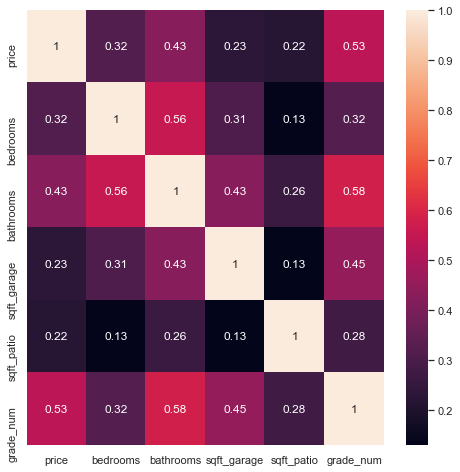

In [291]:
# Correlation heatmap to identify variable most correlated with price

fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(df_model_iqr.corr(), annot=True);

We can see that 'grade_num' has the highest correlation to 'price', followed by 'bathrooms'.

In [292]:
# Creating simple model with the most correlated variable

X = df_model_iqr['grade_num']
y = df_model_iqr['price']

first_model = sm.OLS(y, sm.add_constant(X)).fit()
first_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                 1.066e+04
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:10:40   Log-Likelihood:            -3.8413e+05
No. Observations:               27016   AIC:                         7.683e+05
Df Residuals:                   27014   BIC:                         7.683e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.966e+05   1.69e+04    -47.252      0.000    -8.3e+05   -7.64e+05
grade_num   2.305e+05   2232.607    103.262      0.000    2.26e+05    2.35e+05
==============================================================================
Omnibus:                     2216.346   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2872.605
Skew:                           0.727   Prob(JB):                         0.00
Kurtosis:                       3.662   Cond. No.                         58.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [293]:
# Calculate and return root-mean-square-error for first simple model (RMSE)

np.sqrt(first_model.mse_resid)

362063.0386165129

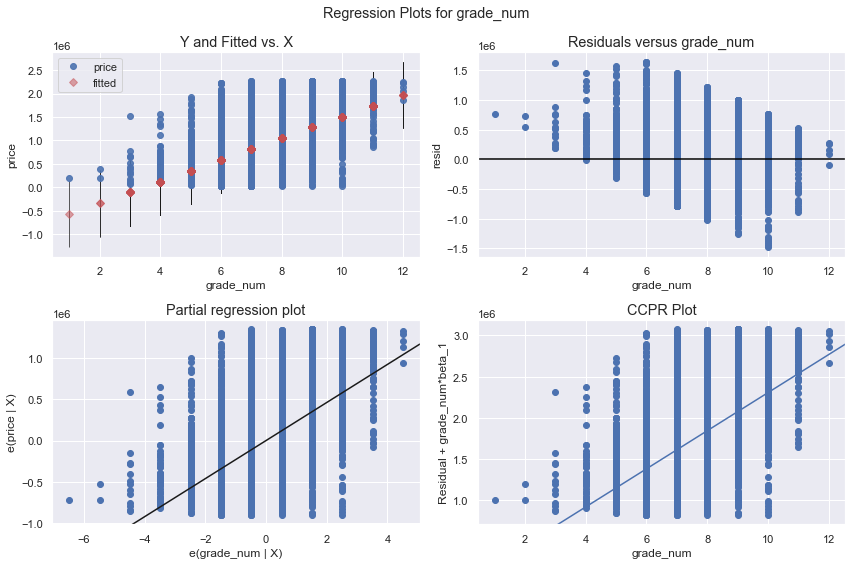

In [294]:
fig = plt.figure(figsize=(12,8))
sm.graphics.plot_regress_exog(first_model, 'grade_num', fig=fig)
plt.show();

## BUILDING MODEL WITH ALL FEATURES

In [295]:
# Create training model with all variables

X = df_model_iqr.drop(columns=['price', 'grade'])
y = df_model_iqr['price']

price_model = sm.OLS(y, sm.add_constant(X)).fit()
price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     2538.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:10:42   Log-Likelihood:            -3.8342e+05
No. Observations:               27016   AIC:                         7.668e+05
Df Residuals:                   27010   BIC:                         7.669e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.018e+05   1.85e+04    -43.296      0.000   -8.38e+05   -7.66e+05
bedrooms      5.35e+04   2719.683     19.673      0.000    4.82e+04    5.88e+04
bathrooms    6.513e+04   3871.745     16.823      0.000    5.75e+04    7.27e+04
sqft_garage  -101.5176      9.572    -10.605      0.000    -120.280     -82.755
sqft_patio    149.6338     13.402     11.165      0.000     123.365     175.903
grade_num    1.886e+05   2818.543     66.929      0.000    1.83e+05    1.94e+05
==============================================================================
Omnibus:                     2137.997   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2813.562
Skew:                           0.695   Prob(JB):                         0.00
Kurtosis:                       3.754   Cond. No.                     3.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [296]:
np.sqrt(price_model.mse_resid)

352712.5417315797

In [297]:
X_standardized = df_model_iqr.drop(columns=['price', 'grade'])

for col in X_standardized:
    X_standardized[col] = (X_standardized[col] - X_standardized[col].mean()) \
                            / X_standardized[col].std()
    
X_standardized.describe()

,bedrooms,bathrooms,sqft_garage,sqft_patio,grade_num
count,2.701600e+04,2.701600e+04,2.701600e+04,2.701600e+04,2.701600e+04
mean,-1.454435e-16,6.706707e-17,8.416260e-17,2.038313e-17,-2.288171e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.502075e+00,-2.813545e+00,-1.179112e+00,-1.028531e+00,-6.574460e+00
25%,-3.616342e-01,-2.872224e-01,-1.179112e+00,-8.502278e-01,-4.933649e-01
50%,-3.616342e-01,3.443583e-01,2.079366e-01,-2.558848e-01,-4.933649e-01
75%,6.851793e-01,3.443583e-01,7.088153e-01,6.356298e-01,5.201509e-01
max,8.012874e+00,6.660165e+00,3.598500e+00,3.060550e+00,4.574214e+00


In [298]:
y = df_model_iqr['price']
X = X_standardized

price_model_std = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()

price_model_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     2538.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:10:42   Log-Likelihood:            -3.8342e+05
No. Observations:               27016   AIC:                         7.668e+05
Df Residuals:                   27010   BIC:                         7.669e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.294e+05   2145.904    433.099      0.000    9.25e+05    9.34e+05
bedrooms     5.111e+04   2598.059     19.673      0.000     4.6e+04    5.62e+04
bathrooms    5.156e+04   3065.123     16.823      0.000    4.56e+04    5.76e+04
sqft_garage -2.635e+04   2484.448    -10.605      0.000   -3.12e+04   -2.15e+04
sqft_patio   2.518e+04   2254.945     11.165      0.000    2.08e+04    2.96e+04
grade_num    1.861e+05   2780.956     66.929      0.000    1.81e+05    1.92e+05
==============================================================================
Omnibus:                     2137.997   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2813.562
Skew:                           0.695   Prob(JB):                         0.00
Kurtosis:                       3.754   Cond. No.                         2.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [299]:
np.sqrt(price_model_std.mse_resid), df_model_iqr['grade_num'].std()

(352712.5417315797, 0.9866644118277742)

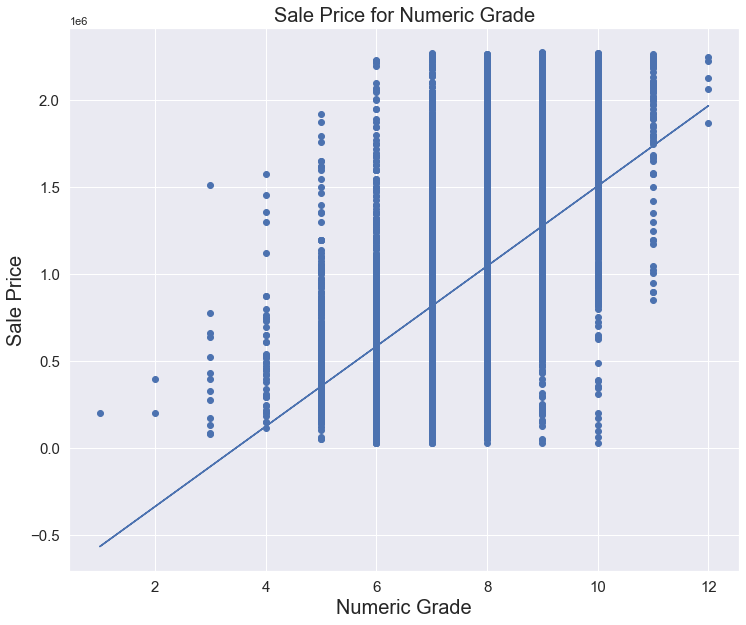

In [300]:
fig, ax = plt.subplots(figsize = (12, 10))

#define data
x = df_model_iqr['grade_num']
y = df_model_iqr['price']

#find line of best fit
a, b = np.polyfit(x, y, 1)

#add points to plot
fig = plt.scatter(x, y)

#add line of best fit to plot
plt.plot(x, a*x+b)

plt.xlabel('Numeric Grade', size=20)
plt.xticks(fontsize=15)
plt.ylabel('Sale Price', size=20)
plt.yticks(fontsize=15)
plt.title('Sale Price for Numeric Grade', size=20)
plt.show(fig);

## IDENTIFYING HOMEOWNER RENOVATION IMPACT ON PRICE

In [301]:


X = df_model_iqr.drop(columns=['price', 'grade', 'grade_num'])
y = df_model_iqr['grade_num']

grade_model = sm.OLS(y, sm.add_constant(X)).fit()
grade_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grade_num   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     4588.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:10:43   Log-Likelihood:                -30968.
No. Observations:               27016   AIC:                         6.195e+04
Df Residuals:                   27011   BIC:                         6.199e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.8959      0.018    334.104      0.000       5.861       5.930
bedrooms       -0.0267      0.006     -4.551      0.000      -0.038      -0.015
bathrooms       0.5629      0.008     73.833      0.000       0.548       0.578
sqft_garage     0.0010   1.98e-05     48.414      0.000       0.001       0.001
sqft_patio      0.0008   2.86e-05     26.862      0.000       0.001       0.001
==============================================================================
Omnibus:                      514.982   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              821.199
Skew:                           0.189   Prob(JB):                    4.78e-179
Kurtosis:                       3.765   Cond. No.                     1.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [302]:
np.sqrt(grade_model.mse_resid)

0.7614228229469279

In [303]:
X_centered = df_model_iqr.drop(columns=['price', 'grade'])

for col in X_centered.columns:
    X_centered[col] = X_centered[col] - X_centered[col].mean()
    
X_centered.describe()

,bedrooms,bathrooms,sqft_garage,sqft_patio,grade_num
count,2.701600e+04,2.701600e+04,2.701600e+04,2.701600e+04,2.701600e+04
mean,-1.159866e-16,2.748435e-17,3.635824e-14,1.427398e-14,-2.945691e-17
std,9.552800e-01,7.916645e-01,2.595439e+02,1.682530e+02,9.866644e-01
min,-3.345462e+00,-2.227384e+00,-3.060313e+02,-1.730534e+02,-6.486786e+00
25%,-3.454619e-01,-2.273838e-01,-3.060313e+02,-1.430534e+02,-4.867856e-01
50%,-3.454619e-01,2.726162e-01,5.396869e+01,-4.305338e+01,-4.867856e-01
75%,6.545381e-01,2.726162e-01,1.839687e+02,1.069466e+02,5.132144e-01
max,7.654538e+00,5.272616e+00,9.339687e+02,5.149466e+02,4.513214e+00


In [304]:
y = df_model_iqr['grade_num']
X = X_centered.drop(columns=['grade_num'])

model_centered = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()

model_centered.params

const          7.486786
bedrooms      -0.026709
bathrooms      0.562912
sqft_garage    0.000960
sqft_patio     0.000767
dtype: float64

In [305]:
# Standardize data so mean = 0 and standard deviation = 1

X_standardized = df_model_iqr.drop(columns=['price', 'grade'])

for col in X_standardized:
    X_standardized[col] = (X_standardized[col] - X_standardized[col].mean()) \
                            / X_standardized[col].std()
    
X_standardized.describe()

,bedrooms,bathrooms,sqft_garage,sqft_patio,grade_num
count,2.701600e+04,2.701600e+04,2.701600e+04,2.701600e+04,2.701600e+04
mean,-1.454435e-16,6.706707e-17,8.416260e-17,2.038313e-17,-2.288171e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.502075e+00,-2.813545e+00,-1.179112e+00,-1.028531e+00,-6.574460e+00
25%,-3.616342e-01,-2.872224e-01,-1.179112e+00,-8.502278e-01,-4.933649e-01
50%,-3.616342e-01,3.443583e-01,2.079366e-01,-2.558848e-01,-4.933649e-01
75%,6.851793e-01,3.443583e-01,7.088153e-01,6.356298e-01,5.201509e-01
max,8.012874e+00,6.660165e+00,3.598500e+00,3.060550e+00,4.574214e+00


In [306]:
y = df_model_iqr['grade_num']
X = X_standardized.drop(columns=['grade_num'])

grade_model_std = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()

grade_model_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grade_num   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     4588.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:10:43   Log-Likelihood:                -30968.
No. Observations:               27016   AIC:                         6.195e+04
Df Residuals:                   27011   BIC:                         6.199e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.4868      0.005   1616.144      0.000       7.478       7.496
bedrooms       -0.0255      0.006     -4.551      0.000      -0.037      -0.015
bathrooms       0.4456      0.006     73.833      0.000       0.434       0.457
sqft_garage     0.2491      0.005     48.414      0.000       0.239       0.259
sqft_patio      0.1291      0.005     26.862      0.000       0.120       0.138
==============================================================================
Omnibus:                      514.982   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              821.199
Skew:                           0.189   Prob(JB):                    4.78e-179
Kurtosis:                       3.765   Cond. No.                         2.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [307]:
np.sqrt(grade_model_std.mse_resid)

0.7614228229469279

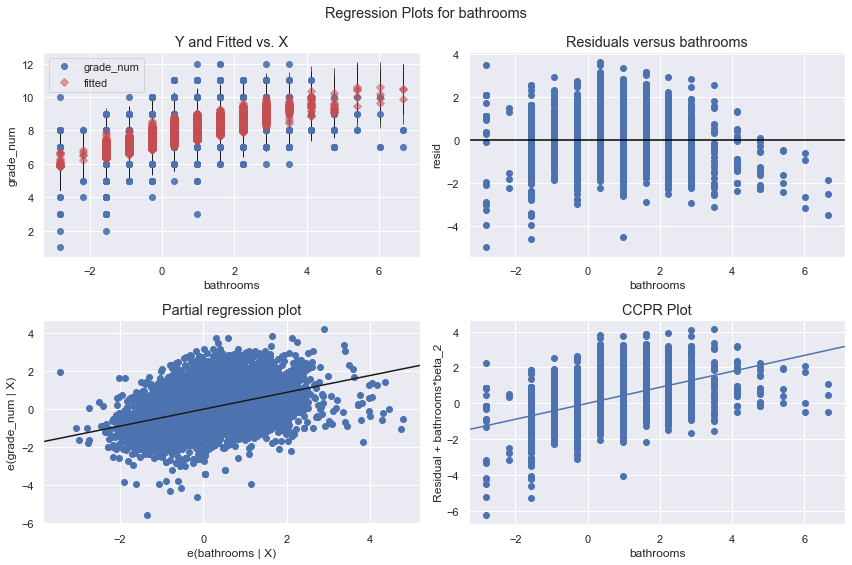

In [308]:
fig = plt.figure(figsize=(12,8))
sm.graphics.plot_regress_exog(grade_model_std, 'bathrooms', fig=fig)
plt.show()

In [309]:
df_model_iqr['sqft_garage'].std(), df_model_iqr['sqft_garage'].median()

(259.5438993747928, 360.0)